#Installation and cloning

In [89]:
!pip install -U openmim
!mim install mmcv-full

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html


In [90]:
#clone th mmsegmentation repo from open-mmlab
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 13734, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 13734 (delta 118), reused 184 (delta 46), pack-reused 13398
Receiving objects: 100% (13734/13734), 16.47 MiB | 26.19 MiB/s, done.
Resolving deltas: 100% (9738/9738), done.
/content/mmsegmentation/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation/mmsegmentation
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmsegmentation
    Found existing installation: mmsegmentation 0.30.0
    Can't uninstall 'mmsegmentation'. No files were found to uninstall.
  Running setup.py develop for mmsegmentation


#download the dataset

--2023-02-24 14:58:06--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  8.58MB/s    in 1.6s    

2023-02-24 14:58:07 (8.58 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



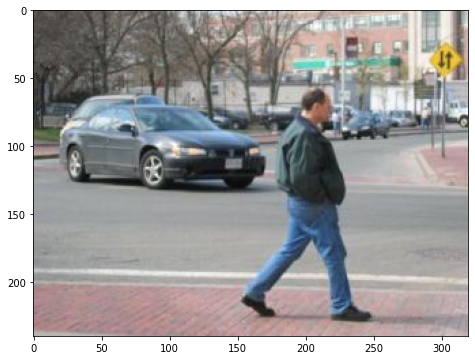

In [91]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [92]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

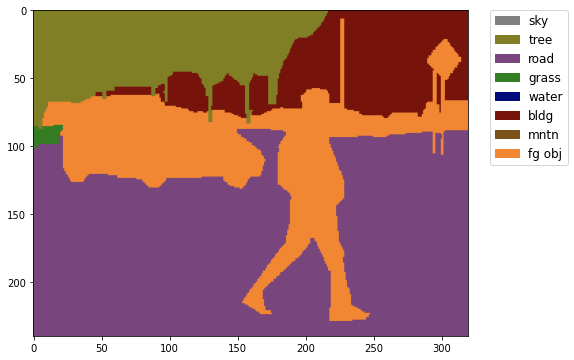

In [93]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [94]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [95]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [96]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

KeyError: ignored

# Modeling and configration

In [97]:
checkpoint_file = '/content/mmsegmentation/checkpoints/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth'
config_file  ='/content/mmsegmentation/configs/upernet/upernet_r18_512x512_160k_ade20k.py'

In [98]:
#create a checkpoint folder
!mkdir checkpoints

#https://github.com/open-mmlab/mmcv/blob/master/mmcv/model_zoo/mmcls.json
!wget https://download.openmmlab.com/mmclassification/v0/swin-transformer/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth -P checkpoints


--2023-02-24 14:58:39--  https://download.openmmlab.com/mmclassification/v0/swin-transformer/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.24.216, 47.246.24.210, 47.246.24.209, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.24.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114376069 (109M) [application/octet-stream]
Saving to: ‘checkpoints/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth’

swin_tiny_224_b16x6 100%[===================>] 109.08M  37.6MB/s    in 2.9s    

2023-02-24 14:58:42 (37.6 MB/s) - ‘checkpoints/swin_tiny_224_b16x64_300e_imagenet_20210616_090925-66df6be6.pth’ saved [114376069/114376069]



In [99]:
from mmcv import Config
cfg = Config.fromfile(config_file)


In [100]:
print(f'Config:\n{cfg.pretty_text}')


Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet18_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='UPerHead',
        in_channels=[64, 128, 256, 512],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=150,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=2,
        channels=256,
   

In [101]:
#if you are using single gpu change the type to BN
cfg.norm_cfg.type='BN'
cfg.model.pretrained=None

## backbone

In [102]:
cfg.model.backbone

{'type': 'ResNetV1c',
 'depth': 18,
 'num_stages': 4,
 'out_indices': (0, 1, 2, 3),
 'dilations': (1, 1, 1, 1),
 'strides': (1, 2, 2, 2),
 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True},
 'norm_eval': False,
 'style': 'pytorch',
 'contract_dilation': True}

In [103]:
'''
pretrain_img_size (int | tuple[int]): The size of input image when
            pretrain. Defaults: 224.
        in_channels (int): The num of input channels.
            Defaults: 3.
        embed_dims (int): The feature dimension. Default: 96.
        patch_size (int | tuple[int]): Patch size. Default: 4.
        window_size (int): Window size. Default: 7.
        mlp_ratio (int | float): Ratio of mlp hidden dim to embedding dim.
            Default: 4.
        depths (tuple[int]): Depths of each Swin Transformer stage.
            Default: (2, 2, 6, 2).
        num_heads (tuple[int]): Parallel attention heads of each Swin
            Transformer stage. Default: (3, 6, 12, 24).
        strides (tuple[int]): The patch merging or patch embedding stride of
            each Swin Transformer stage. (In swin, we set kernel size equal to
            stride.) Default: (4, 2, 2, 2).
        out_indices (tuple[int]): Output from which stages.
            Default: (0, 1, 2, 3).
        qkv_bias (bool, optional): If True, add a learnable bias to query, key,
            value. Default: True
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Default: None.
        patch_norm (bool): If add a norm layer for patch embed and patch
            merging. Default: True.
        drop_rate (float): Dropout rate. Defaults: 0.
        attn_drop_rate (float): Attention dropout rate. Default: 0.
        drop_path_rate (float): Stochastic depth rate. Defaults: 0.1.
        use_abs_pos_embed (bool): If True, add absolute position embedding to
            the patch embedding. Defaults: False.
        act_cfg (dict): Config dict for activation layer.
            Default: dict(type='LN').
        norm_cfg (dict): Config dict for normalization layer at
            output of backone. Defaults: dict(type='LN').
        with_cp (bool, optional): Use checkpoint or not. Using checkpoint
            will save some memory while slowing down the training speed.
            Default: False.
        pretrained (str, optional): model pretrained path. Default: None.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters.
        init_cfg (dict, optional): The Config for initialization.
            Defaults to None.
    """
'''

cfg.model.backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=512,
        embed_dims=96,
        depths=(2, 2, 6, 2),
        num_heads=(3, 6, 12, 24),
        window_size=7,
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://swin_tiny')
        )

In [104]:
cfg.model.backbone

{'type': 'SwinTransformer',
 'pretrain_img_size': 512,
 'embed_dims': 96,
 'depths': (2, 2, 6, 2),
 'num_heads': (3, 6, 12, 24),
 'window_size': 7,
 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://swin_tiny'}}

##decoded head

In [105]:
cfg.model.decode_head

{'type': 'UPerHead',
 'in_channels': [64, 128, 256, 512],
 'in_index': [0, 1, 2, 3],
 'pool_scales': (1, 2, 3, 6),
 'channels': 512,
 'dropout_ratio': 0.1,
 'num_classes': 150,
 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True},
 'align_corners': False,
 'loss_decode': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 1.0}}

In [106]:
cfg.model.decode_head.loss_decode.avg_non_ignore=True

In [107]:
cfg.model.decode_head.in_channels=[96, 192, 384, 768]


In [108]:
cfg.model.decode_head.num_classes=len(classes)

In [109]:
cfg.model.decode_head.norm_cfg.type="BN"

In [110]:
cfg.model.decode_head

{'type': 'UPerHead',
 'in_channels': [96, 192, 384, 768],
 'in_index': [0, 1, 2, 3],
 'pool_scales': (1, 2, 3, 6),
 'channels': 512,
 'dropout_ratio': 0.1,
 'num_classes': 8,
 'norm_cfg': {'type': 'BN', 'requires_grad': True},
 'align_corners': False,
 'loss_decode': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 1.0,
  'avg_non_ignore': True}}

##auxiliary_head


In [111]:
cfg.model.auxiliary_head

{'type': 'FCNHead',
 'in_channels': 256,
 'in_index': 2,
 'channels': 256,
 'num_convs': 1,
 'concat_input': False,
 'dropout_ratio': 0.1,
 'num_classes': 150,
 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True},
 'align_corners': False,
 'loss_decode': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 0.4}}

In [112]:
cfg.model.auxiliary_head.num_classes=len(classes)
cfg.model.auxiliary_head.loss_decode.avg_non_ignore=True
cfg.model.auxiliary_head.in_channels=384
cfg.model.auxiliary_head.norm_cfg.type="BN"

In [113]:
cfg.model.auxiliary_head

{'type': 'FCNHead',
 'in_channels': 384,
 'in_index': 2,
 'channels': 256,
 'num_convs': 1,
 'concat_input': False,
 'dropout_ratio': 0.1,
 'num_classes': 8,
 'norm_cfg': {'type': 'BN', 'requires_grad': True},
 'align_corners': False,
 'loss_decode': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 0.4,
  'avg_non_ignore': True}}

In [114]:
cfg.optimizer=dict(type='Adam', lr=0.0003, weight_decay=0.0001)

In [115]:
cfg.lr_config = dict(
    policy='CosineAnnealing',
    warmup='linear',
    warmup_iters=1000,
    warmup_ratio=1.0 / 10,
    min_lr_ratio=1e-5)  # Whether count by epoch or not.

In [116]:
#cfg.optimizer=dict(type='Adam', lr=0.0003, weight_decay=0.0001)

##data

In [117]:
# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

In [118]:
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu=2

In [119]:

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

In [120]:
cfg.data

{'samples_per_gpu': 2,
 'workers_per_gpu': 2,
 'train': {'type': 'StanfordBackgroundDataset',
  'data_root': 'iccv09Data',
  'img_dir': 'images',
  'ann_dir': 'labels',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'LoadAnnotations'},
   {'type': 'RandomCrop', 'crop_size': (512, 512), 'cat_max_ratio': 0.75},
   {'type': 'RandomFlip', 'flip_ratio': 0.5},
   {'type': 'PhotoMetricDistortion'},
   {'type': 'Normalize',
    'mean': [123.675, 116.28, 103.53],
    'std': [58.395, 57.12, 57.375],
    'to_rgb': True},
   {'type': 'Pad', 'size': (512, 512), 'pad_val': 0, 'seg_pad_val': 255},
   {'type': 'DefaultFormatBundle'},
   {'type': 'Collect', 'keys': ['img', 'gt_semantic_seg']}],
  'split': 'splits/train.txt'},
 'val': {'type': 'StanfordBackgroundDataset',
  'data_root': 'iccv09Data',
  'img_dir': 'images',
  'ann_dir': 'labels',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'type': 'MultiScaleFlipAug',
    'img_scale': (320, 240),
    'flip': False,
    'transforms': [{'t

In [121]:
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

In [122]:
cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.evaluation.metric='mIoU'
cfg.checkpoint_config.interval = 200

In [123]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

In [124]:
cfg.CUDA_VISIBLE_DEVICES=0 
cfg.GPUS=1

In [125]:
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]
cfg.device = get_device()

In [126]:
print(f'Config:\n{cfg.pretty_text}')


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=512,
        embed_dims=96,
        depths=(2, 2, 6, 2),
        num_heads=(3, 6, 12, 24),
        window_size=7,
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://swin_tiny')),
    decode_head=dict(
        type='UPerHead',
        in_channels=[96, 192, 384, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=1.0,
            avg_non_ignore=True)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=384,
        in_index=2,
        channels=256,
        num_convs=1,
        c

In [127]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor,init_segmentor,single_gpu_test


# Build the dataset
datasets = [build_dataset(cfg.data.train)]



2023-02-24 14:58:43,395 - mmseg - INFO - Loaded 572 images


In [128]:
# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [129]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))


In [130]:
train_segmentor(model, datasets, cfg,distributed=False)

2023-02-24 14:58:44,163 - mmseg - INFO - Start running, host: root@6569a843eac4, work_dir: /content/mmsegmentation/mmsegmentation/work_dirs/tutorial
2023-02-24 14:58:44,164 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook                     
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 ------------

In [131]:
!python tools/analyze_logs.py work_dirs/tutorial/None.log.json --keys loss --legend loss --out work_dirs/tutorial/loss


plot curve of work_dirs/tutorial/None.log.json, metric is loss
save curve to: work_dirs/tutorial/loss
